# Prototype Spatial Analytics
This notebook performs example spatial analytics that are based on interviews we conducted with Epidemiologists at Fairfax County. More details about Fairfax County Spatial Analytics use cases are documented in this Google [Doc](https://docs.google.com/document/d/1l3HAq-skWRRF_lm8Cf659uvvx7lTbBUm526-RsAse10/edit#heading=h.45gyn9vnonff).

**Note, all data in this notebook is synthetic**.

1. Dataset Requirements
    1. I assume that the dataset, in whatever format it's stored in (e.g. Parquet) can be read in some relational format. This notebook assumes dataframe in Pandas; however, R DataFrames, SAS, Stata, etc. would be analgous.
    1. For this initial use case for breakthrough infection analytics, I assume the following fields:
        1. pprl_generated_id (Primary Key)
        1. first_name
        1. last_name
        1. street_address
        1. zip_code
        1. latitude
        1. longitude
        1. census_tract
        1. census_block_group
        1. census_block
        1. is_fully_vax
        1. tested_covid_positive
        1. breakthrough_infection
    1. External Datasets
        1. To perform geospatial mapping, we require shapefiles of the underlying Polygons. For example, in this notebook we used Virginia's Shapefile for Census Block Groups ([Link](https://data.virginia.gov/Government/2019-Virginia-Census-Block-Groups/gtta-aa5t/data))
        1. Virginia Census Tract Datafile [Link](https://catalog.data.gov/dataset/tiger-line-shapefile-2018-state-virginia-current-census-tract-state-based)
        1. In addition, Fairfax County Parcel Data can be obtained [here](https://data-fairfaxcountygis.opendata.arcgis.com/datasets/parcels/explore?location=38.865890%2C-77.354937%2C16.00&showTable=true)
        1. Longer term, we may need to figure out some library to access Census shapefile data more robustly.
        
Comment for the future -- it would be helpful, in addition, to geocoding with SmartyStreets, to also pull in data, e.g. socioeconomic data, that can be joined at census geography levels (e.g. https://www.neighborhoodatlas.medicine.wisc.edu/  Area Deprivation Index created at Census Block Group Level)

In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import pandas as pd

import phdi_analytics as pa

# Generate Synthetic Data
Generate synthetic data if doesn't exist. Should only have to do this once, we save as a pickle file so that you don't have to regenerate each time. The only reason why this takes a while is because we are actually geocoding the fake datapoints.

In [2]:
if os.path.exists(os.path.join(pa.OUTPUTS_DIR, 'synthetic_df.pkl')):
    df = pd.read_pickle(os.path.join(pa.OUTPUTS_DIR, 'synthetic_df.pkl'))
    df['event_dt'] = pd.to_datetime(df['event_dt'])
else:
    df = pa.create_dataframe(radius=20000, number_of_points=10000, center=pa.FAIRFAX_COUNTY_CENTER)

  0%|          | 0/10000 [00:00<?, ?it/s]

# Analytics

I found this Medium [Post](https://towardsdatascience.com/mapping-census-data-fbab6722def0) and [notebook](https://github.com/allisoncstafford/seattle_tree_canopy_blog/blob/master/census_ethnicity.ipynb) to be helpful

In [3]:
df.head()

,pprl_generated_id,first_name,last_name,street_address,zip_code,latitude,longitude,event_dt,census_tract,census_block_group,census_block,is_fully_vax,tested_covid_positive,breakthrough_infection
0,5624,Test First Name,Test Last Name,Test 123 Street,22180,38.946777,-77.460231,2021-08-11,51107980100,511079801001,511079801001010,0,0,0
1,8169,Test First Name,Test Last Name,Test 123 Street,22042,38.891403,-77.512368,2022-03-26,51107611813,511076118134,511076118134004,1,0,0
2,1536,Test First Name,Test Last Name,Test 123 Street,22043,38.747485,-77.417149,2021-07-09,51153901231,511539012311,511539012311011,1,0,0
3,260,Test First Name,Test Last Name,Test 123 Street,22180,38.820324,-77.294044,2021-11-06,51059430203,510594302031,510594302031000,1,0,0
4,6656,Test First Name,Test Last Name,Test 123 Street,22182,38.771534,-77.389472,2021-06-02,51059492500,510594925002,510594925002051,1,0,0


## Time Series Graphs

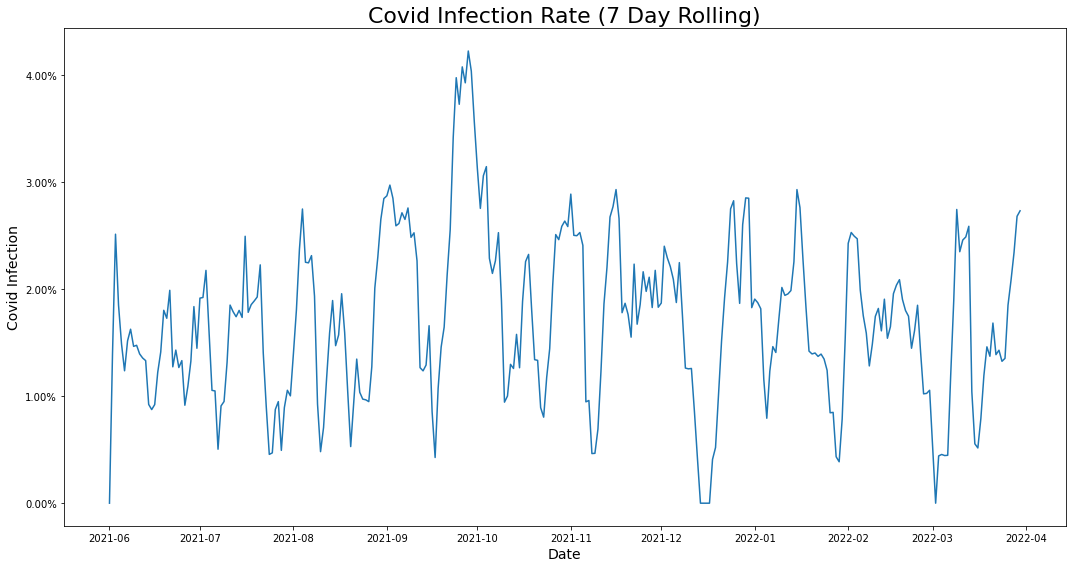

In [4]:
fig, ax = pa.plot_time_series_metric(df=df, window='7D', metric_label='Covid Infection')
plt.show()

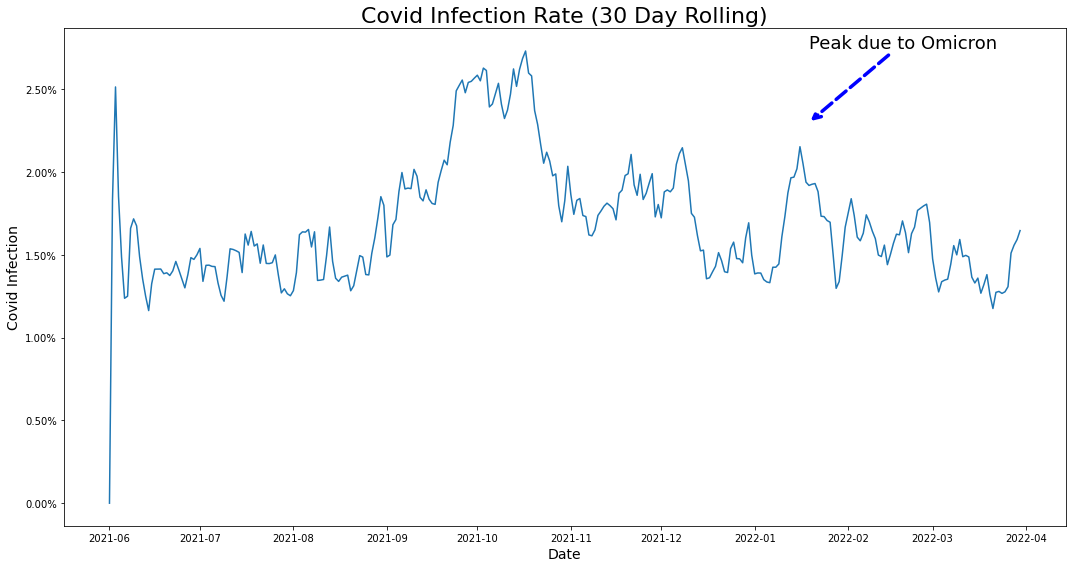

In [5]:
fig, ax = pa.plot_time_series_metric(df=df, window='30D', metric_label='Covid Infection')

ax.annotate(
    'Peak due to Omicron',
    xy=(dt.datetime(2022, 1, 19), 0.023),
    xytext=(dt.datetime(2022, 1, 19), 0.0275),
    arrowprops=dict(arrowstyle= '->', color='blue', lw=3.5, ls='--'),
    fontsize=18,
)

plt.show()

## Spatial Analytics

<AxesSubplot:title={'center':'Fairfax County Breakthrough Infection Rate (2020 Census Block Groups)'}>

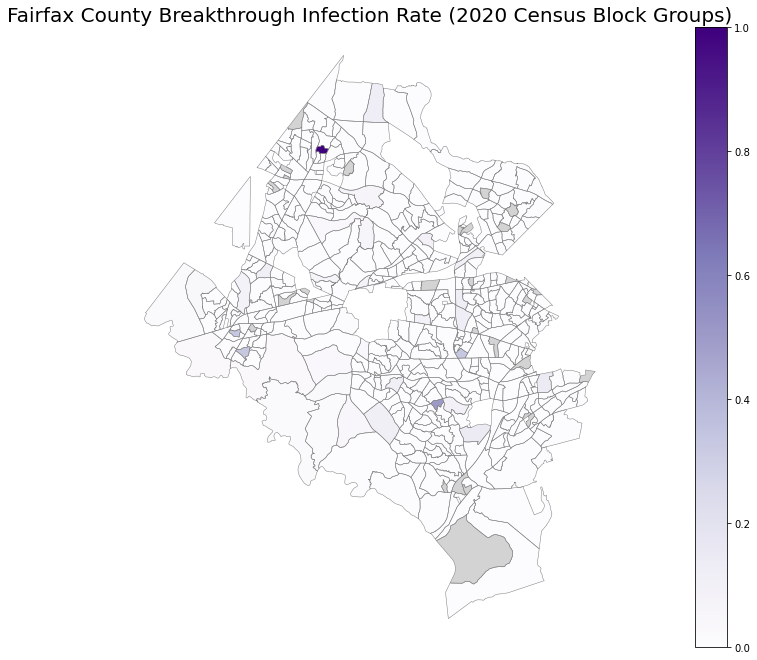

In [6]:
pa.create_map(
    geography='census_block_group',
    shapefile_path=pa.VA_CBG_MAP_PATH,
    metric='breakthrough_infection_rate',
    df=df
)

<AxesSubplot:title={'center':'Fairfax County Breakthrough Infection Rate (2020 Census Tracts)'}>

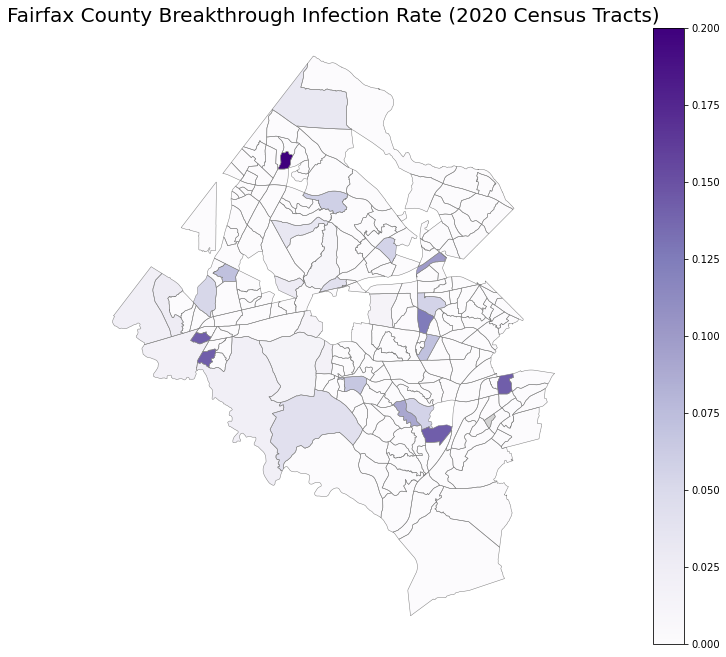

In [7]:
pa.create_map(
    geography='census_tract',
    shapefile_path=pa.VA_TRACT_MAP_PATH,
    metric='breakthrough_infection_rate',
    df=df
)